<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/bert_finetuning_YouTube_clickbait_domain_adaption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
#Check GPU, if assigned k8 then factory reset couple of times until we get Tesla GPU
!nvidia-smi

Sat Jul 17 09:42:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.3MB 9.9MB/s 
     |████████████████████████████████| 1.6MB 8.2MB/s 
     |████████████████████████████████| 686kB 53.0MB/s 
     |████████████████████████████████| 37.2MB 79kB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 358kB 49.1MB/s 
     |████████████████████████████████| 215kB 56.5MB/s 
     |████████████████████████████████| 645kB 41.5MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 1.2MB 45.3MB/s 


#Imports

In [38]:
import os, math
import numpy as np
import pandas as pd
import requests
import shutil
import re
from pathlib import Path
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization


from tensorflow import keras
from official.nlp import optimization  # to create AdamW optmizer
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

tf.get_logger().setLevel('ERROR')

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')
from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

In [4]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Configs

##Bert configs

In [5]:
#@title "Model mappings"
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4'
}

In [6]:
#@title "Bert pretrained model downlaod"
tfhub_handle_encoder = map_name_to_handle[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)

bert_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='bert_encoder')
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4


##General config

In [7]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'
stop_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/Stop_clickbait/tfrec_data/'

model_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/saved_models'
saved_model_name = f'youtube_clickbait_finetuned_domain_adapted_{bert_model_name}'
saved_model_path = os.path.join(model_root_path, saved_model_name )

checkpoint_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints'
model_checkpoint_path = os.path.join(checkpoint_root_path, f'youtube_clickbait_finetuned_domain_adapted_{bert_model_name}_checkpoint' )


BATCH_SIZE = 32  
# Label categories
label_list = [0,1]
# maximum length of (token) input sequences
max_seq_len = 128
init_lr = 2e-5

epochs = 5

#Scripts

In [8]:
#@title "Utilities [TF Dataset]"
def read_tfrecord(example):
    features = {
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string)  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    return text, class_num, label

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.shuffle(num_train_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.cache().prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

In [9]:
#@title "Utilities [Map bert preprocessing to Dataset]"
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_len, tokenizer=bert_tokenizer):
  example = classifier_data_lib.InputExample(guid=None, text_a=text.numpy(), text_b=None, label=label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], Tout=[tf.int32,tf.int32, tf.int32, tf.int32 ])
  input_ids.set_shape([max_seq_len])
  segment_ids.set_shape([max_seq_len])
  input_mask.set_shape([max_seq_len])
  label_id.set_shape([])

  x = {
       'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids':segment_ids
  }
  
  return (x, label_id)
  

In [10]:
#@title "Utilities [Create Model Definition]"
def create_model():

 encoder_inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_word_ids"),
    input_mask=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,  name="input_mask"),
    input_type_ids=tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_type_ids"),
)
 
 net = bert_layer(encoder_inputs)['pooled_output']

 net = tf.keras.layers.Dropout(0.2)(net)
 net = tf.keras.layers.Dense(384, activation='ReLU', name='dense_384')(net)
 net = tf.keras.layers.Dropout(0.2)(net)
 output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

 model = tf.keras.Model(
     encoder_inputs,
     outputs=output,
     name='prediction'
 )
 return model

In [53]:
#@title "Utilities [Model prediction]"
def get_metrics(y_test, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(y_test, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    print(matrix)

def predict_on_test_dataset(model, test_data, BATCH_SIZE=32):
  y_true=[]
  
  for text_feat, labels in test_data:
    for i in range(BATCH_SIZE):
      y_true.append(labels[i].numpy())


  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  vh.plot_cm(y_true, predicted_scores)
  print()

#Read TFRecord data

In [12]:
#@title  "Load files & Split"
#instantiate read_data utility
read_YouTube_data = read_tfrec_data(tfrec_trainVal_files_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_stop_clickbait_data = read_tfrec_data(stop_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
YouTube_filenames, YouTube_training_filenames, YouTube_validation_filenames, YouTube_testing_filenames = read_YouTube_data.get_tfrec_files()

stop_clickbait_filenames, stop_clickbait_training_filenames,stop_clickbait_validation_filenames, stop_clickbait_testing_filenames = read_stop_clickbait_data.get_tfrec_files()

filenames = YouTube_filenames + stop_clickbait_filenames
training_filenames = YouTube_training_filenames + stop_clickbait_training_filenames
validation_filenames = YouTube_validation_filenames + stop_clickbait_validation_filenames

random.shuffle(filenames)
random.shuffle(training_filenames)
random.shuffle(validation_filenames)

#len(filenames), len(training_filenames), len(validation_filenames)

num_train_examples = 974 * len(YouTube_training_filenames) + 500 * len(stop_clickbait_training_filenames)
num_total_examples = 974 * len(YouTube_filenames) + 500 * len(stop_clickbait_filenames)

validation_steps = int(num_total_examples  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(num_total_examples  // len(filenames) * len(training_filenames)) // BATCH_SIZE

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))



Pattern matches 14 data files. Splitting dataset into 12 training files , 2 validation files and 0 test files
Pattern matches 64 data files. Splitting dataset into 52 training files , 12 validation files and 0 test files
With a batch size of 32, there will be 1170 batches per training epoch and 255 batch(es) per validation run.


In [13]:
#instantiate read_data utility for test set
read_test_data = read_tfrec_data(tfrec_test_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
testing_filenames, _, _,_ = read_test_data.get_tfrec_files()
len(testing_filenames)

Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files


2

#Load TFRecord into TF Dataset

In [14]:
# create the datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  val_ds = load_dataset(validation_filenames)
  test_ds = load_dataset(testing_filenames)

In [15]:
for i,(text, class_num, label) in enumerate(train_ds.take(10)):
  print(f"text : {text.numpy()}, class : {class_num.numpy()}, label : {label.numpy()}")

text : b'omggggg minecraft video youtubers life with morgz omg we start a minecraft lets play today we have episode of a hilarious new game called youtubers life in this game we try and grow a youtube channel and gain subscribers fast it s not actually real though it gets a bit confusing anyway this game was so fun to play and i had such a laugh growing a channel and starting that minecraft lets play if you want to see the next episode of this epic series then lets smash likes if we hit that you will see part three also i worked so hard on this edit it took me over hours i am so happy with how this video turned out from start to finish and i think it could be one of my most entertaining videos on the channel do you agree tell me in the comment section below enjoy the video be sure to watch till the end yo guys first of all thank you so much for watching it would be great if you could leave a like rating as it motivates me to keep creating content for you all also if you are new then pl

In [16]:
with tf.device('/cpu:0'):
  train_ds = train_ds.map(lambda text, class_num, label:(text, class_num))
  val_ds = val_ds.map(lambda text, class_num, label:(text, class_num))
  test_ds = test_ds.map(lambda text, class_num, label:(text, class_num))

#Modeling

##Bert preprocessing

In [17]:
with tf.device('/cpu:0'):
  # train
  train_data = train_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train_data = get_batched_dataset(train_data, train=True)

  # valid
  val_data = val_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  val_data = get_batched_dataset(val_data)

  # test
  test_data = test_ds.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  test_data = get_batched_dataset(test_data)
  

In [18]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

#Build classifier

In [19]:
classifier_model = create_model()
classifier_model.summary()

Model: "prediction"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_encoder (KerasLayer)       {'pooled_output': (N 109482241   input_mask[0][0]                 
                                                                 input_type_ids[0][0]    

#Train classifier model

##Compile model

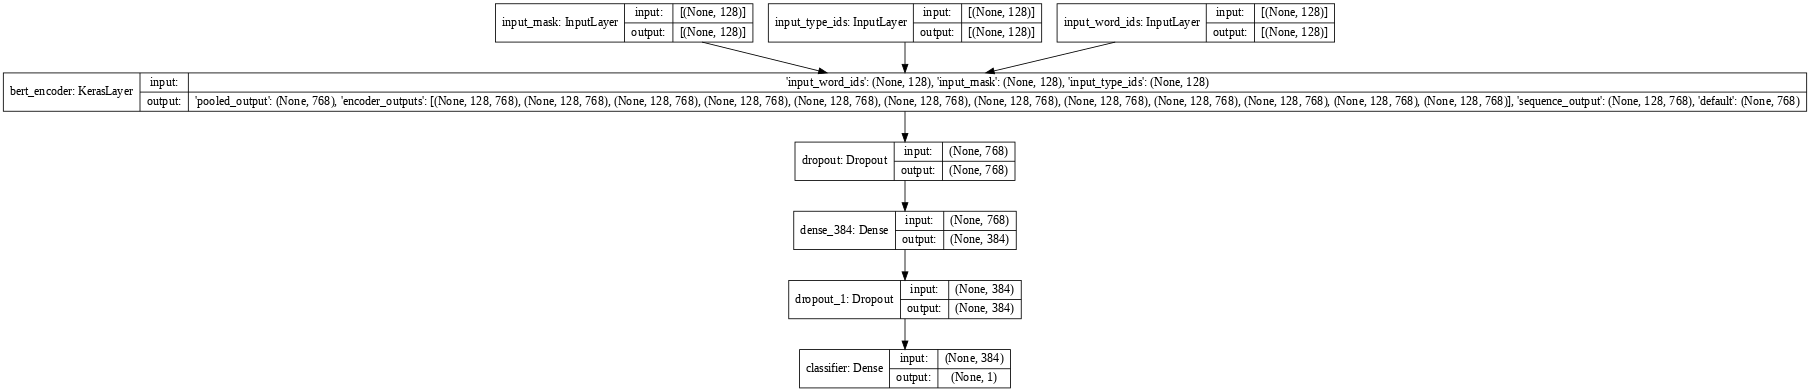

In [20]:
es = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', 
          verbose=1, 
          patience=5, 
          mode='min', 
          restore_best_weights=True
          )

mcb = tf.keras.callbacks.ModelCheckpoint (
         filepath=model_checkpoint_path,
         save_weights_only=True,
         monitor='val_prc',
         mode='max',
         verbose=1,
         save_best_only=True
        )

METRICS = [
             keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn'), 
             keras.metrics.BinaryAccuracy(name='accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc'),
             keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw'
      )

classifier_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
    )

tf.keras.utils.plot_model(model=classifier_model, show_shapes=True, dpi=60)

In [21]:
#@title Load weights if available
if os.path.exists(model_checkpoint_path):
  print('loading saved weight')
  classifier_model.load_weights(model_checkpoint_path)
else:
  print('No weight to initialize')

No weight to initialize


##Train

In [22]:
history = classifier_model.fit(
             x=train_data,
             validation_data=val_data,
             steps_per_epoch=steps_per_epoch,
             epochs=epochs,
             validation_steps=validation_steps,
             callbacks=[es, mcb]
             )

Epoch 1/5
1170/1170 [==============================] - 1154s 928ms/step - loss: 0.1744 - tp: 17234.0000 - fp: 1720.0000 - tn: 17412.0000 - fn: 1074.0000 - accuracy: 0.9254 - precision: 0.9093 - recall: 0.9413 - auc: 0.9809 - prc: 0.9792 - val_loss: 0.0612 - val_tp: 3759.0000 - val_fp: 80.0000 - val_tn: 4020.0000 - val_fn: 77.0000 - val_accuracy: 0.9802 - val_precision: 0.9792 - val_recall: 0.9799 - val_auc: 0.9967 - val_prc: 0.9962

Epoch 00001: val_prc improved from -inf to 0.99618, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_domain_adapted_bert_en_uncased_L-12_H-768_A-12_checkpoint
Epoch 2/5
1170/1170 [==============================] - 1009s 863ms/step - loss: 0.0462 - tp: 18025.0000 - fp: 224.0000 - tn: 18933.0000 - fn: 258.0000 - accuracy: 0.9871 - precision: 0.9877 - recall: 0.9859 - auc: 0.9970 - prc: 0.9960
Epoch 3/5
1170/1170 [==============================] - 1009s 862ms/step - los

In [35]:
# Save model weights
classifier_model.save_weights(model_checkpoint_path)

#Plot train history

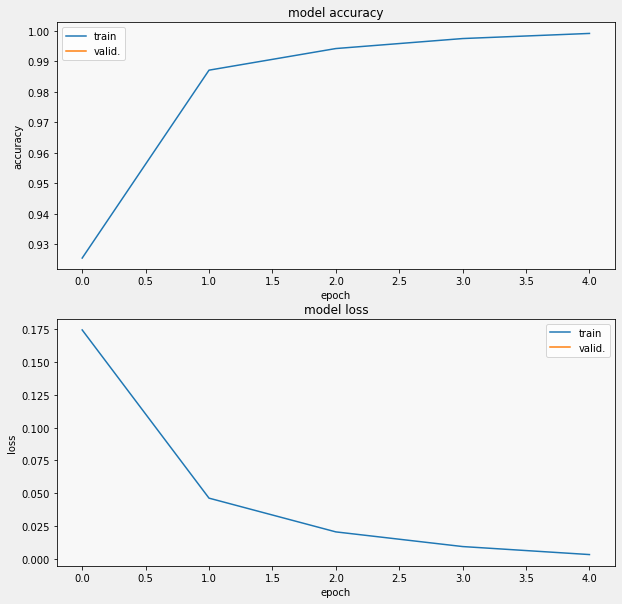

In [32]:
vh.display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

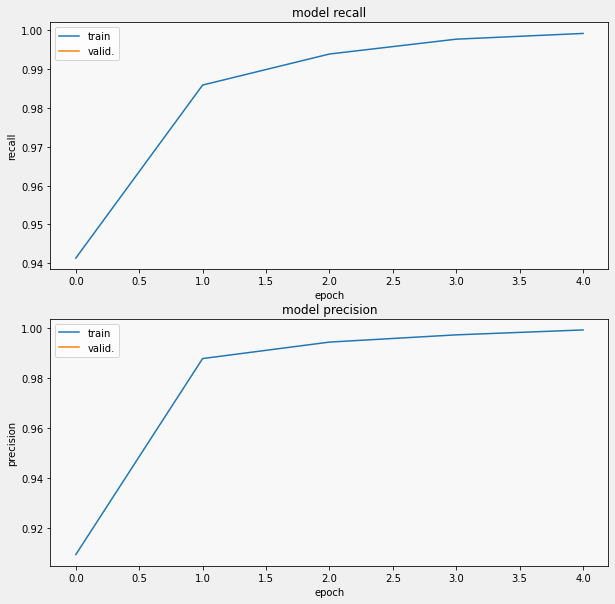

In [33]:
vh.display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
vh.display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

#Evaluate model

In [34]:
results = classifier_model.evaluate(test_data)

for name, value in zip(classifier_model.metrics_names, results):
  print(name, ': ', value)
print()

60/60 [==============================] - 20s 322ms/step - loss: 0.1574 - tp: 871.0000 - fp: 21.0000 - tn: 1002.0000 - fn: 26.0000 - accuracy: 0.9755 - precision: 0.9765 - recall: 0.9710 - auc: 0.9841 - prc: 0.9788
loss :  0.15740805864334106
tp :  871.0
fp :  21.0
tn :  1002.0
fn :  26.0
accuracy :  0.9755208492279053
precision :  0.976457417011261
recall :  0.9710144996643066
auc :  0.9841058254241943
prc :  0.9788302779197693



#Export for inference

In [55]:
classifier_model.save(saved_model_path, include_optimizer=False)

#Model prediction

In [56]:
saved_classifier = keras.models.load_model(saved_model_path)

Accuracy: 0.975521
Precision: 0.976457
Recall: 0.971014
F1 score: 0.973728
ROC AUC: 0.975243
[[1002   21]
 [  26  871]]
Non clickbaits Detected (True Negatives):  1002
Non-Clickbaits Detected as Clickbaits (False Positives):  21
Clickbaits Detected as Non-clickbaits (False Negatives):  26
Clickbaits Detected (True Positives):  871
Total Non-clickbaits:  1023
Total Clickbaits:  897



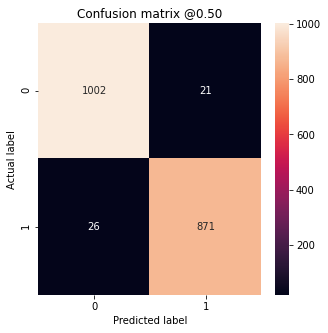

In [58]:
predict_on_test_dataset(saved_classifier, test_data, BATCH_SIZE=BATCH_SIZE)